In [150]:
# création d'un dataset avec chaque année et chaque variable économique
import import_ipynb
import utils
# chaque cellule de chaque dataset correspond aux données par évenement olympique

data_pop = utils.generate_df_from_files("./data_cleaned/population", "_population")
data_fertility = utils.generate_df_from_files("./data_cleaned/fertility", "_fertility")
data_child = utils.generate_df_from_files("./data_cleaned/child_mortality", "_child_mortality")
data_capita = utils.generate_df_from_files("./data_cleaned/gdp_capita", "_gdp_capita")
#data_life = utils.generate_df_from_files("./data_cleaned/life_expectancy_by_years", "_life_expectancy")
data_pop = data_pop[11:]
data_fertility = data_fertility[11:]
data_child = data_child[11:]
data_capita = data_capita[11:]

In [ ]:
# chargement des labels a partir d'ici il faudra répéter cette opération pour chaque événement olympique
# test pour 1992
import pandas as pd
df_delegations = pd.read_csv("./second_part_countries_cleaned_normalized.csv")


In [ ]:
y = df_delegations.iloc[:, :-1]
y = y.iloc[0, :]

In [137]:
y

Albania       0.333333
Algeria       1.000000
Andorra       0.000000
Angola        0.500000
Argentina     0.000000
                ...   
Uzbekistan    0.000000
Venezuela     0.000000
Vietnam       0.000000
Zambia        0.750000
Zimbabwe      0.000000
Name: 0, Length: 163, dtype: float64

In [151]:
import numpy as np

X = np.concatenate((
    data_pop[0].iloc[:, 1:], 
    data_fertility[0].iloc[:,1:], 
    data_child[0].iloc[:,1:], 
    data_capita[0].iloc[:,1:] 
), axis=1)


In [152]:
X[:].shape

(163, 4)

In [153]:
len(y)

163

In [154]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the MLP model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),  # Input layer with 128 neurons
    Dense(64, activation='relu'),  # Hidden layer with 64 neurons
    Dense(32, activation='relu'),  # Another hidden layer with 32 neurons
    Dense(1)  # Output layer (1 neuron for regression)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Mean Absolute Error (MAE): {mae:.4f}")

# Make predictions (optional)
predictions = model.predict(X_test)


c:\Users\Julien\miniconda3\envs\PCD\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - loss: 0.1872 - mae: 0.2647 - val_loss: 0.1789 - val_mae: 0.2793
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1740 - mae: 0.2828 - val_loss: 0.1628 - val_mae: 0.3090
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1439 - mae: 0.2864 - val_loss: 0.1601 - val_mae: 0.3359
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1382 - mae: 0.3081 - val_loss: 0.1674 - val_mae: 0.3629
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1434 - mae: 0.3236 - val_loss: 0.1696 - val_mae: 0.3715
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1499 - mae: 0.3354 - val_loss: 0.1687 - val_mae: 0.3719
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1372 - mae: 0.3213 - val_loss: 0.1625 - val_mae: 0.3612
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1403 - mae: 0.3211 - val_loss: 0.1570 - val_mae: 0.3500
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1318 - mae:

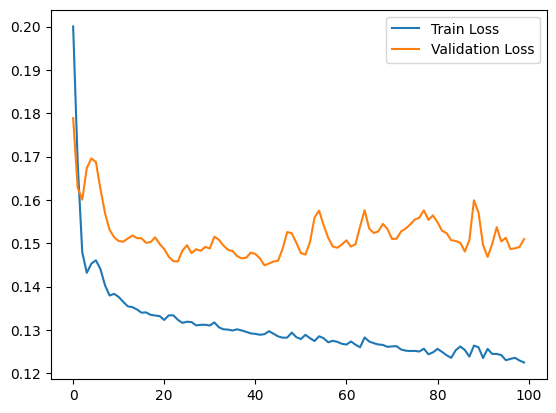

In [155]:
# plot de history pour voir l'évolution de la loss et de la mae
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()